In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
cd D:/HKU/Project for STAT7008/data1/classification_data

D:/HKU/Project for STAT7008/data1/classification_data


In [21]:
embed_size = 200 # how big is each word vector
max_features = 880 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a comment to use

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [23]:
train.head(5)

,no.,date,retweets,text
0,1,2018/9/14 7:56,26,b'Typhoon Mangkhut: Millions in Philippines br...
1,2,2018/9/14 7:55,1,"b'Here in the Philippines, staying online as l..."
2,3,2018/9/14 7:51,783,b'Typhoon Mangkhut as it approaches the Philip...
3,4,2018/9/14 7:47,3,"b'Your Thursday News Briefing: Pope Francis, T..."
4,5,2018/9/14 7:56,26,b'Typhoon Mangkhut: Millions in Philippines br...


In [24]:
test.head(5)

,no.,date,retweets,text
0,1,2018/11/2 7:54,1,b'Seabees from NMCB ONE are in Tinian to help ...
1,2,2018/11/2 7:40,15,b'The Northern Mariana Islands of Tinian and S...
2,3,2018/11/2 7:30,2,b'I bet that by the time Saipan and Tinian hav...
3,4,2018/11/2 6:59,3,b'Great morning # MayWard fam! 8days of no Soc...
4,5,2018/11/2 6:56,2,b'Praying for the people of the Northern Maria...


In [25]:
train.describe()

,no.,retweets
count,25965.000000,25965.000000
mean,12983.000000,23.685731
std,7495.594206,108.506492
min,1.000000,0.000000
25%,6492.000000,0.000000
50%,12983.000000,1.000000
75%,19474.000000,10.000000
max,25965.000000,783.000000


In [26]:
test.describe()

,no.,retweets
count,6033.000000,6033.000000
mean,3017.000000,7.956241
std,1741.721419,19.963912
min,1.000000,0.000000
25%,1509.000000,0.000000
50%,3017.000000,0.000000
75%,4525.000000,2.000000
max,6033.000000,73.000000


In [27]:
list_sentences_train = train["text"].values
y = train["retweets"].values
list_sentences_test = test["text"].values

In [28]:
y.shape[0]

25965

In [29]:
def get_label():
    for i in range(y.shape[0]):
        if y[i] > 0:
            y[i] = 1
    return y

In [30]:
y = get_label()

In [31]:
tokenizer = Tokenizer(num_words=max_features) #num_words用来初始化一个Tokenizer类，表示用多少词语生成词典
tokenizer.fit_on_texts(list(list_sentences_train))#fit_on_texts是Tokenizer的一个method，只有对于一个texts学习后，才有这些attribute，比如word_counts等。
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)#将多个文档转换为word下标的向量形式,shape为[len(texts)，len(text)] -- (文档数，每条文档的长度)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [32]:
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)#将序列填充到maxlen长度，padding取值有pre|post，value指定用何值填充的值
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [33]:
X_test.shape

(6033, 200)

In [34]:
#Read the glove word vectors (space delimited strings) into a dictionary from word->vector.
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open("D:/HKU/Project for STAT7008/data1/classification_data",'rb'))

In [35]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [36]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix.shape

(880, 200)

In [41]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model.fit(X_train, y, batch_size=30, epochs=2, validation_split=0.2)

Train on 20772 samples, validate on 5193 samples
Epoch 1/2
20772/20772 [==============================] - 440s 21ms/step - loss: 0.0299 - acc: 0.9906 - val_loss: 1.3747 - val_acc: 0.7237
Epoch 2/2
20772/20772 [==============================] - 438s 21ms/step - loss: 1.5738e-04 - acc: 1.0000 - val_loss: 0.9825 - val_acc: 0.7789


Train on 20772 samples, validate on 5193 samples
Epoch 1/2
20772/20772 [==============================] - 459s 22ms/step - loss: 0.0284 - acc: 0.9900 - val_loss: 1.5164 - val_acc: 0.6684
Epoch 2/2
20772/20772 [==============================] - 1434s 69ms/step - loss: 2.7611e-05 - acc: 1.0000 - val_loss: 1.5977 - val_acc: 0.7789


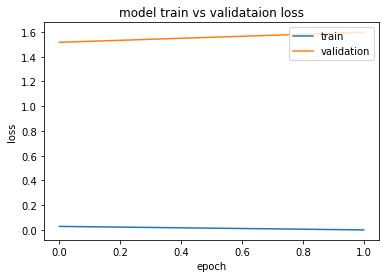

In [42]:
from matplotlib import pyplot as plt
history = model.fit(X_train, y, batch_size=30, epochs=2, validation_split=0.2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validataion loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()